# Animal Detection Demo

This notebook demonstrates the usage of two models:
1. Image Classification model for identifying animals in images
2. Named Entity Recognition (NER) model for detecting animal mentions in text

Finally, we'll combine both approaches to create a comprehensive animal detection system.

In [1]:
import torch
from torchvision import transforms
from PIL import Image
import os
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from models.classifier.resnet import ResNet50
import random

/home/svyatoslav/PythonProjects/WinstarsTestTask/task2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Part 1: Image Classification

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the image classification model
MODEL_PATH = "./models/classifier/classification_model/model.pth"
model = ResNet50(3, 10).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Define image transformation pipeline
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Class labels
class_labels = {
    0: "butterfly", 1: "cat", 2: "cock", 3: "cow", 4: "dog",
    5: "elephant", 6: "horse", 7: "sheep", 8: "spider", 9: "squirrel"
}

Using device: cuda


In [3]:
def predict_image(image_path):
    """Predict the class of a single image."""
    try:
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        # Make prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted_class = torch.max(outputs, 1)
        
        # Get class name
        class_id = predicted_class.item()
        class_name = class_labels.get(class_id, f"Unknown (ID: {class_id})")
        
        return class_name
    except Exception as e:
        return f"Error processing image: {str(e)}"


Class: dog


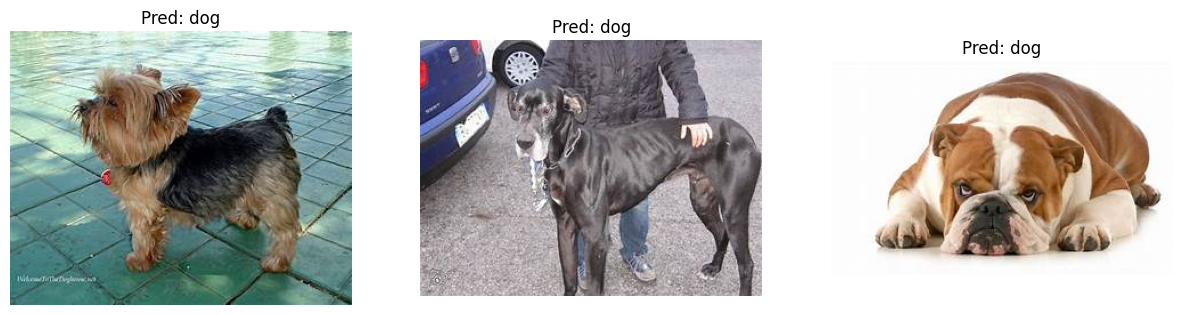

----------------------------------------
Class: horse


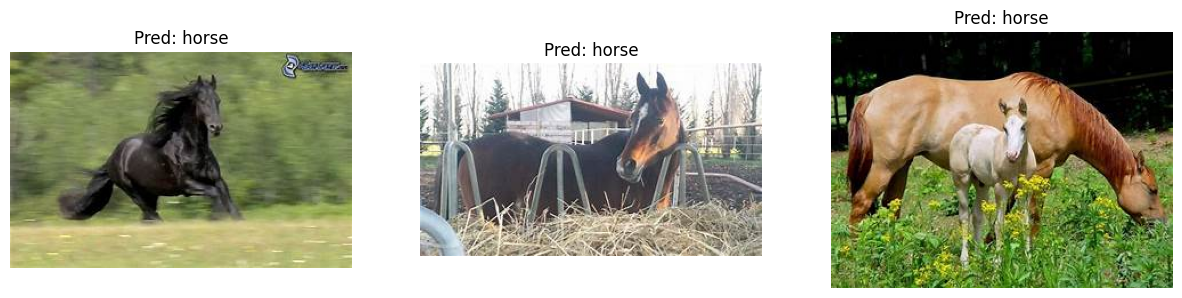

----------------------------------------
Class: butterfly


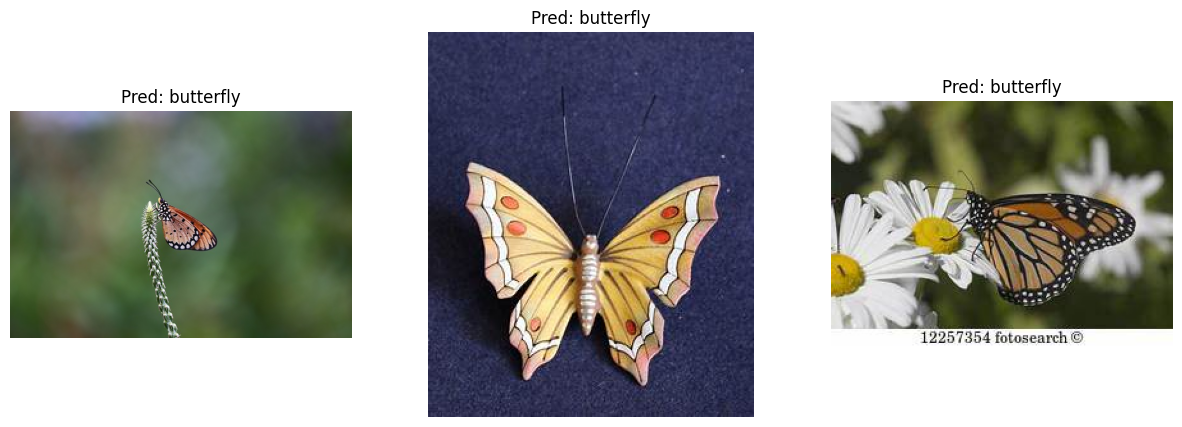

----------------------------------------
Class: cow


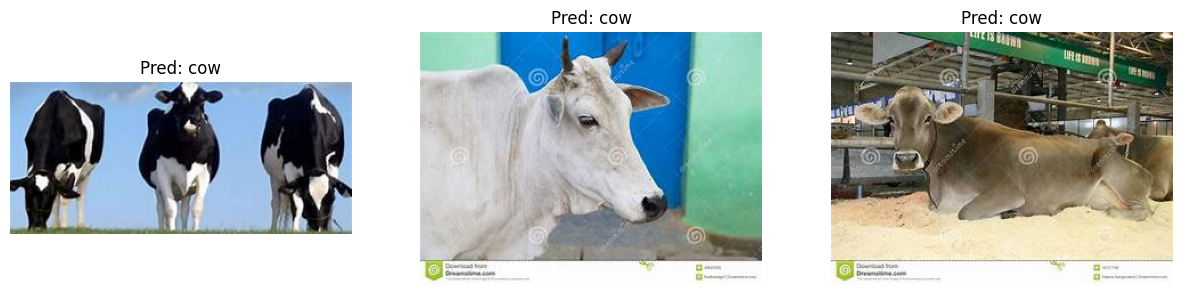

----------------------------------------
Class: squirrel


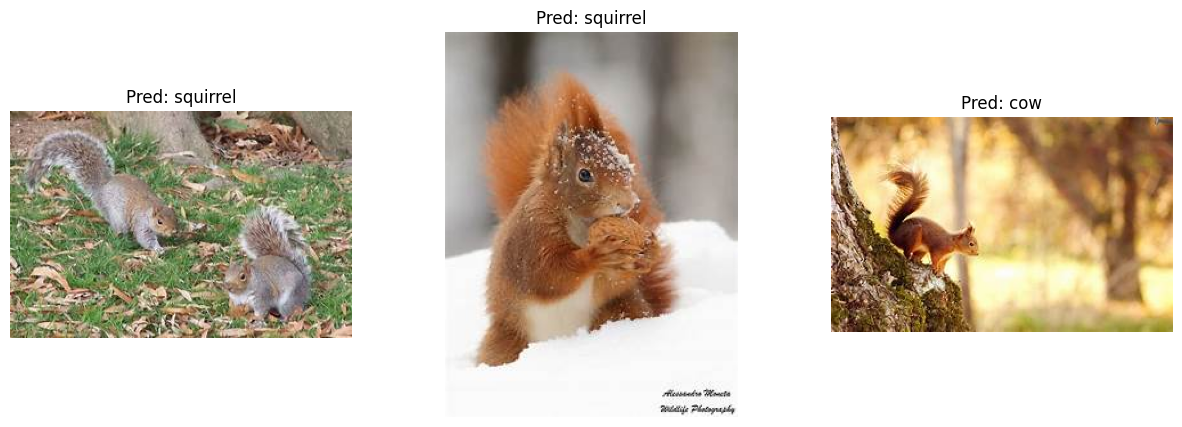

----------------------------------------
Class: sheep


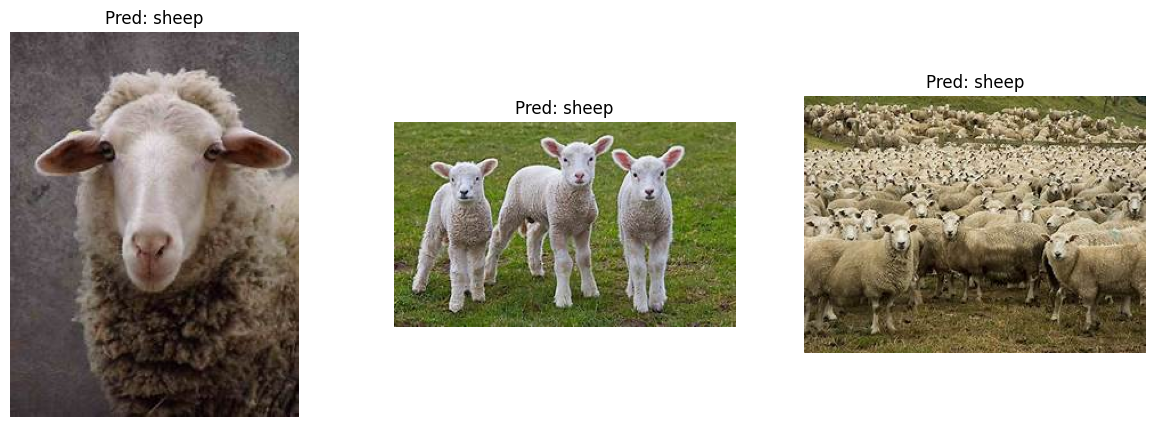

----------------------------------------
Class: cat


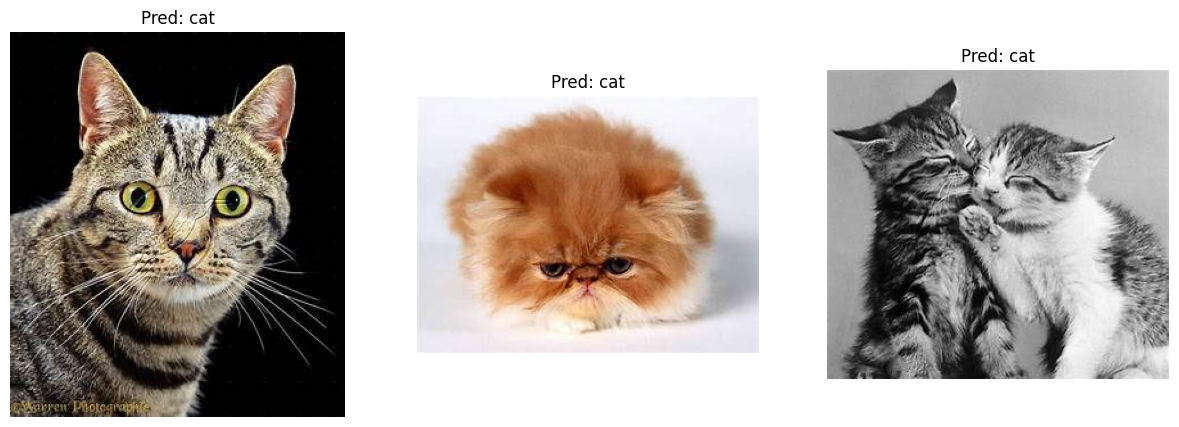

----------------------------------------
Class: elephant


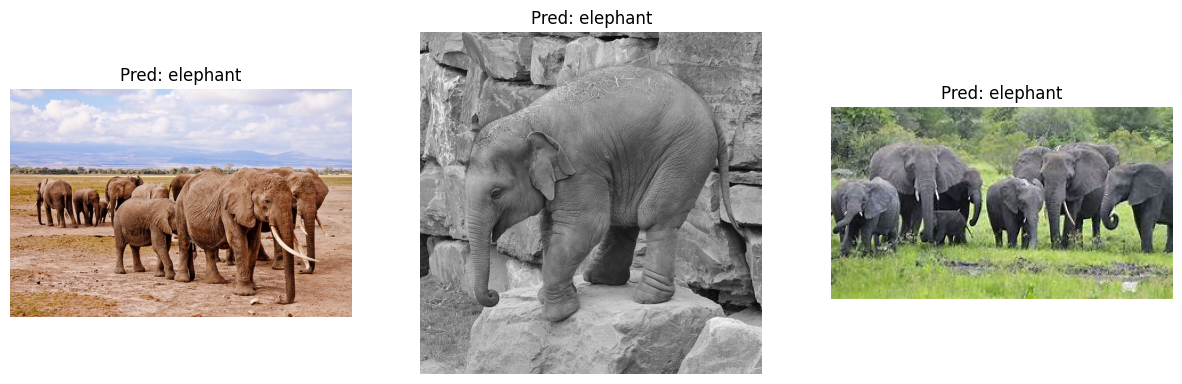

----------------------------------------
Class: cock


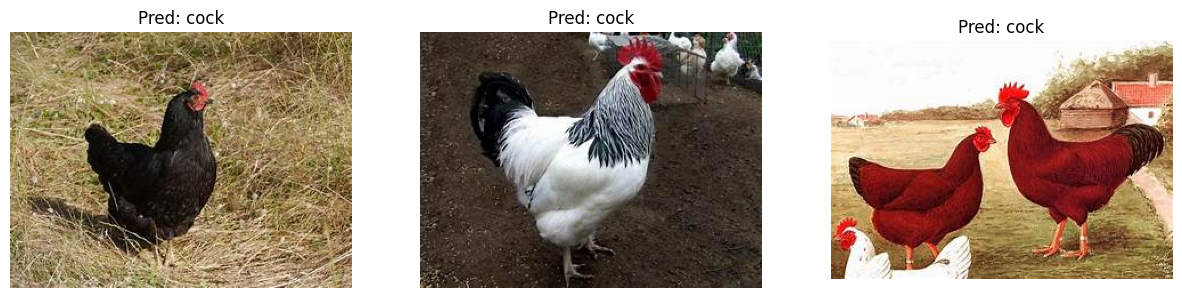

----------------------------------------
Class: spider


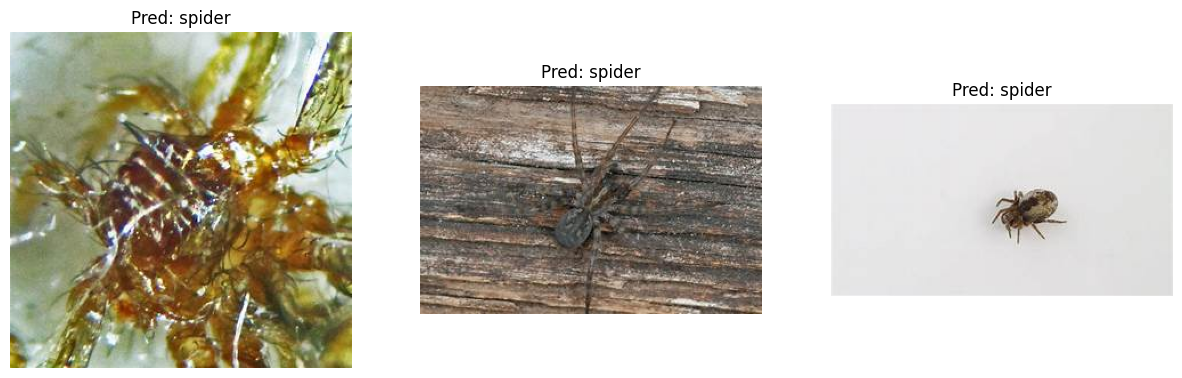

----------------------------------------


In [4]:
import matplotlib.pyplot as plt

def predict_images_from_test_dir(test_dir):
    """Predict the class for three random images from each class directory and display them."""
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            if len(images) >= 3:
                random_images = random.sample(images, 3)
            else:
                random_images = images  
                
            print(f"Class: {class_name}")
            fig, axes = plt.subplots(1, len(random_images), figsize=(15, 5))
            
            if len(random_images) == 1:
                axes = [axes]  
            
            for ax, img in zip(axes, random_images):
                image_path = os.path.join(class_path, img)
                prediction = predict_image(image_path)
                
                image = Image.open(image_path)
                ax.imshow(image)
                ax.axis("off")
                ax.set_title(f"Pred: {prediction}")
                
                # print(f"  Image: {img} → Predicted class: {prediction}")
            
            plt.show()
            print("-" * 40)

# Запуск тестування
test_dir = "./data_split/test"
predict_images_from_test_dir(test_dir)


## Part 2: Named Entity Recognition for Animals

In [6]:
# Load the NER model
model_dir = "./models/ner/animal_ner_model"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
ner_model = AutoModelForTokenClassification.from_pretrained(model_dir)
ner_pipeline = pipeline("ner", model=ner_model, tokenizer=tokenizer)

def extract_animals(text):
    """Extract animal mentions from text."""
    ner_results = ner_pipeline(text)
    animals = [entity["word"] for entity in ner_results if entity["entity"] == "LABEL_1"]
    return animals

# Test sentences
test_sentences = [
    "I saw a cat chasing a butterfly in my garden while my dog was sleeping.",
    "The elephant at the zoo was massive, and nearby there was a horse giving rides to children.",
    "On the farm, I saw a cow, some sheep, and a cock crowing at dawn.",
    "A spider built its web near where a squirrel was gathering nuts.",
    "I like dog.",
    "The lion roared loudly.",
    "A rabbit jumped over the fence.",
    "I saw a dolphin swimming in the ocean.",
    "The kangaroo was hopping across the field."
]

# Test NER on sample sentences
for sentence in test_sentences:
    animals = extract_animals(sentence)
    print(f"Text: {sentence}")
    print(f"Detected animals: {animals}\n")


Device set to use cuda:0


Text: I saw a cat chasing a butterfly in my garden while my dog was sleeping.
Detected animals: ['cat', 'butterfly', 'dog']

Text: The elephant at the zoo was massive, and nearby there was a horse giving rides to children.
Detected animals: ['elephant', 'horse']

Text: On the farm, I saw a cow, some sheep, and a cock crowing at dawn.
Detected animals: ['cow', 'sheep', 'cock', 'crow']

Text: A spider built its web near where a squirrel was gathering nuts.
Detected animals: ['spider', 'squirrel']

Text: I like dog.
Detected animals: ['dog']

Text: The lion roared loudly.
Detected animals: ['lion']

Text: A rabbit jumped over the fence.
Detected animals: ['rabbit']

Text: I saw a dolphin swimming in the ocean.
Detected animals: ['dolphin']

Text: The kangaroo was hopping across the field.
Detected animals: ['kangaroo']



## Part 3: Combined Analysis

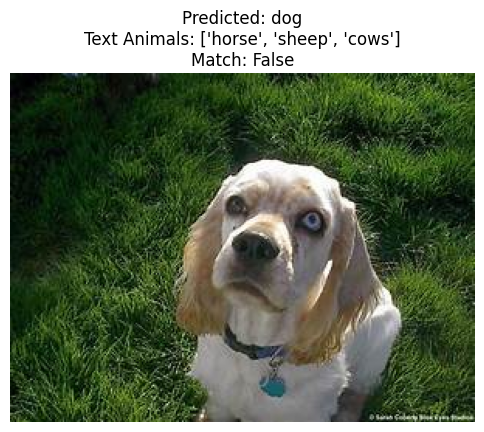

Text: The horse was grazing in the field next to some sheep and cows.
Image classification: dog
Animals mentioned in text: ['horse', 'sheep', 'cows']
Match: False
--------------------------------------------------


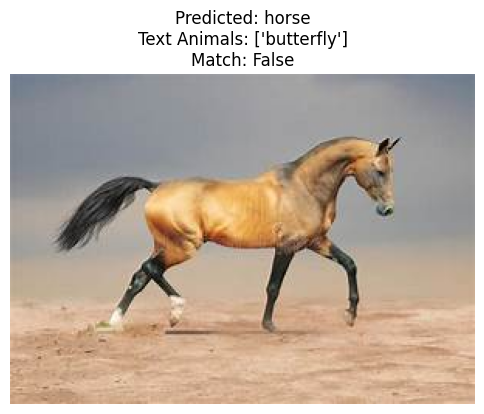

Text: A butterfly landed on a beautiful flower.
Image classification: horse
Animals mentioned in text: ['butterfly']
Match: False
--------------------------------------------------


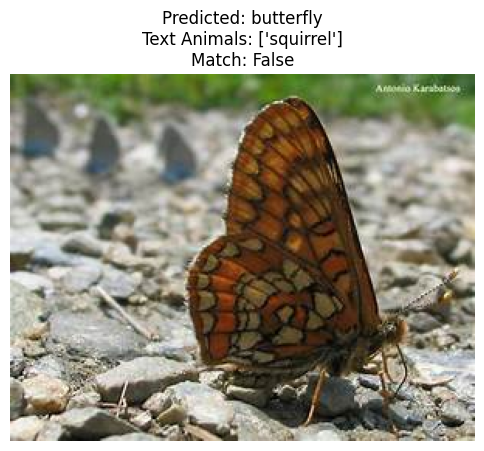

Text: A squirrel was climbing up the tall oak tree.
Image classification: butterfly
Animals mentioned in text: ['squirrel']
Match: False
--------------------------------------------------


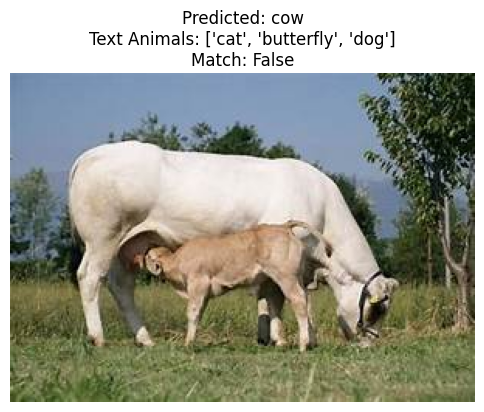

Text: I saw a cat playing with a butterfly in the garden. My dog was watching them.
Image classification: cow
Animals mentioned in text: ['cat', 'butterfly', 'dog']
Match: False
--------------------------------------------------


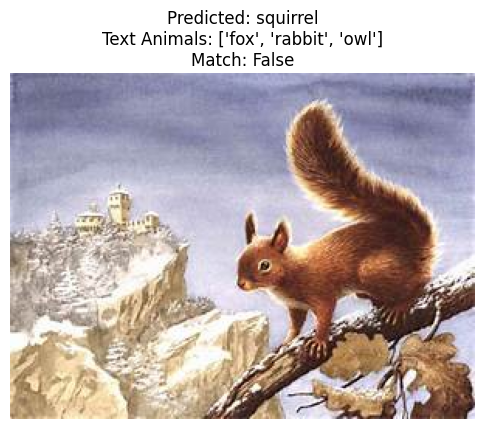

Text: A fox and a rabbit ran through the forest, avoiding the owl above them.
Image classification: squirrel
Animals mentioned in text: ['fox', 'rabbit', 'owl']
Match: False
--------------------------------------------------


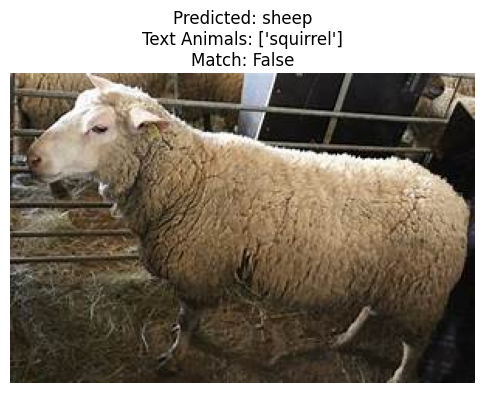

Text: There is a squirrel in the tree.
Image classification: sheep
Animals mentioned in text: ['squirrel']
Match: False
--------------------------------------------------


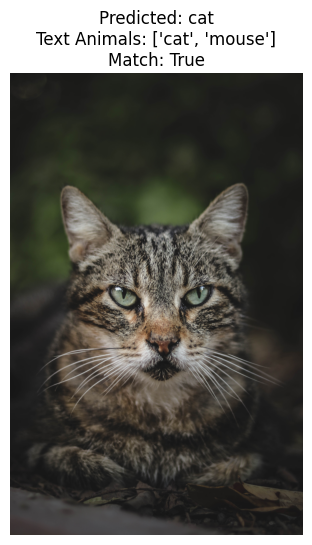

Text: The cat was chasing a mouse in the yard.
Image classification: cat
Animals mentioned in text: ['cat', 'mouse']
Match: True
--------------------------------------------------


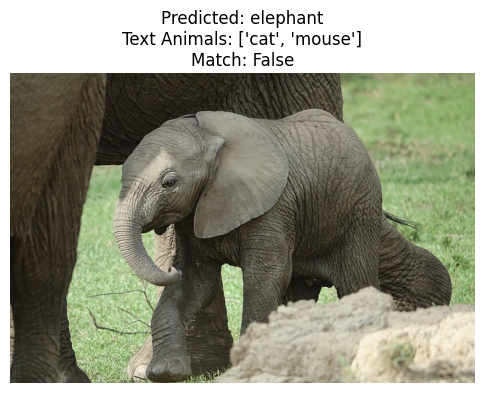

Text: The cat was chasing a mouse in the yard.
Image classification: elephant
Animals mentioned in text: ['cat', 'mouse']
Match: False
--------------------------------------------------


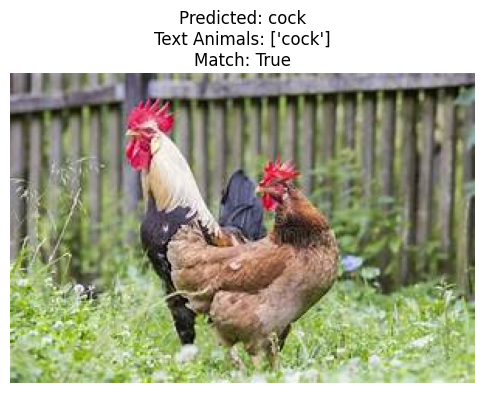

Text: Early in the morning, the cock started crowing.
Image classification: cock
Animals mentioned in text: ['cock']
Match: True
--------------------------------------------------


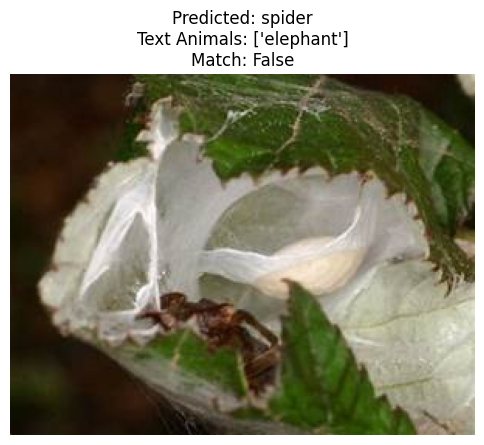

Text: The elephant at the zoo was massive
Image classification: spider
Animals mentioned in text: ['elephant']
Match: False
--------------------------------------------------


In [16]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def analyze_image_and_text(image_path, text):
    """Perform both image classification and text analysis."""
    # Image analysis
    image_prediction = predict_image(image_path)  
    
    # Text analysis
    detected_animals = extract_animals(text)  
    
    match_result = image_prediction.lower() in [animal.lower() for animal in detected_animals]
    
    return {
        'image_prediction': image_prediction,
        'text_animals': detected_animals,
        'match': match_result
    }

def analyze_random_test_images(test_dir, texts):
    """Select random images from test directory, analyze them, and display results."""
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            if not images:
                continue  
            
            image_path = os.path.join(class_path, random.choice(images))
            text = random.choice(texts)  
            
            results = analyze_image_and_text(image_path, text)
            
            
            image = Image.open(image_path)
            plt.figure(figsize=(6, 6))
            plt.imshow(image)
            plt.axis("off")
            plt.title(f"Predicted: {results['image_prediction']}\n"
                      f"Text Animals: {results['text_animals']}\n"
                      f"Match: {results['match']}")
            plt.show()
            
            print(f"Text: {text}")
            print(f"Image classification: {results['image_prediction']}")
            print(f"Animals mentioned in text: {results['text_animals']}")
            print(f"Match: {results['match']}")
            print("-" * 50)


sample_texts = [
    "I saw a cat playing with a butterfly in the garden. My dog was watching them.",
    "The horse was grazing in the field next to some sheep and cows.",
    "A dog and a cat were sitting near the fireplace, enjoying the warmth.",
    "A fox and a rabbit ran through the forest, avoiding the owl above them.",
    "Does it cow in the picture?",
    "There is a squirrel in the tree.",
    "The elephant at the zoo was massive",
    "A butterfly landed on a beautiful flower.",
    "The cat was chasing a mouse in the yard.",
    "Early in the morning, the cock started crowing.",
    "A cow was grazing in the green field.",
    "The dog ran towards its owner with excitement.",
    "At the zoo, I saw a huge elephant drinking water.",
    "The horse galloped across the open plain.",
    "A sheep was resting near the wooden fence.",
    "A spider built a web in the corner of the ceiling.",
    "A squirrel was climbing up the tall oak tree.",
]


test_dir = "./data_split/test"
analyze_random_test_images(test_dir, sample_texts) 